In [52]:
%matplotlib inline 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv1D, Conv3DTranspose, Dropout, MaxPool3D, Flatten, Reshape, Input, Permute, GlobalAvgPool3D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
from random import sample, seed
from tqdm import tqdm
import matplotlib.pyplot as plt

physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass

from utils.losses import focalSoftMSE

In [106]:

class AAE():
    #Adversarial Autoencoder
    def __init__(self, img_shape=(48, 96, 96, 1), encoded_dim=32, optimizer_generator = Adam(0.00005, beta_1=.5), 
                optimizer_discriminator = Adam(0.00001, beta_1=.5), optimizer_autoencoder = Adam(0.0002, beta_1=.9)):
        self.encoded_dim = encoded_dim
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.optimizer_autoencoder = optimizer_autoencoder
        self.img_shape = img_shape
        self.initializer = RandomNormal(mean=0., stddev=1.)
        self.encoder, self.decoder, self.autoencoder, self.discriminator, \
                self.discriminator2, self.generator, self.generator2 = self._modelCompile(
                self.img_shape, self.encoded_dim, \
                self.optimizer_autoencoder,\
                self.optimizer_discriminator,\
                self.optimizer_generator
                )

    def _buildEncoder(self, img_shape, encoded_dim):

        encoder = Sequential()
        encoder.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        encoder.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
#         encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
#         encoder.add(GlobalAvgPool3D())
        encoder.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
        encoder.add(Conv3D(filters = 1, kernel_size=1, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(layers.BatchNormalization())
#         encoder.add(Flatten())
#         encoder.add(Dense(512, activation="relu"))
#         encoder.add(Dropout(0.3))
#         encoder.add(Dense(512, activation="relu"))
#         encoder.add(Dropout(0.3))
#         encoder.add(Dense(encoded_dim))
        
        return encoder

    def _buildDecoder(self, encoded_dim):

        decoder = Sequential()
#         decoder.add(Dense(512, activation='relu', input_dim=encoded_dim))
#         #decoder.add(Dropout(0.3))
#         decoder.add(Dense(512, activation='relu'))
#         #decoder.add(Dropout(0.3))
#         decoder.add(Dense(6*12*12, activation='relu'))
#         #decoder.add(Dropout(0.3))
#         #decoder.add(Reshape([12*24*24,1]))
#         #decoder.add(Conv1D(filters = 64, kernel_size=1, padding='SAME', activation='relu'))
#         #decoder.add(Permute((2,1)))
#         decoder.add(Reshape([6,12,12,1]))
        decoder.add(Conv3DTranspose(filters=128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(layers.BatchNormalization())
        decoder.add(Conv3DTranspose(filters=1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        
        return decoder

    def _buildDiscriminator(self, encoded_dim):

        discriminator = Sequential()
        discriminator.add(Dense(512, input_dim=encoded_dim, activation="relu"))
        discriminator.add(Dense(512, activation="relu"))
        discriminator.add(Dense(64, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))

        return discriminator
    
    def _buildDiscriminator2(self, img_shape):
        
        discriminator = Sequential()
        discriminator.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        #discriminator.add(Conv3D(filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        discriminator.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        discriminator.add(GlobalAvgPool3D())
        #discriminator.add(Conv3D(filters = 1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(Flatten())
        discriminator.add(Dense(128, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))
        
        return discriminator

    def _modelCompile(self, img_shape, encoded_dim, optimizer_autoencoder, optimizer_discriminator, optimizer_generator):

        encoder=self._buildEncoder(img_shape, encoded_dim)
        decoder=self._buildDecoder(encoded_dim)
        
        autoencoder_input = Input(shape = img_shape) # this is the input for autoencoder and main generator
        decoder_input=Input(shape=encoded_dim)
        
        autoencoder=Model(autoencoder_input, decoder(encoder(autoencoder_input)))
        autoencoder.compile(optimizer=optimizer_autoencoder, loss="mse")
        
        discriminator = None
        generator = None
#         discriminator=self._buildDiscriminator(encoded_dim)
#         discriminator.trainable = False
#         generator = Model(autoencoder_input, discriminator(encoder(autoencoder_input)))
#         generator.compile(optimizer=optimizer_generator, loss="mse")
#         discriminator.trainable = True
#         discriminator.compile(optimizer=optimizer_discriminator, loss="mse")
    
        discriminator2 = self._buildDiscriminator2(img_shape)
        discriminator2.trainable = False
        generator2=Model(autoencoder_input, discriminator2(autoencoder(autoencoder_input)))
        generator2.compile(optimizer=optimizer_generator, loss="mse")
        discriminator2.trainable = True
        discriminator2.compile(optimizer=optimizer_discriminator, loss="mse")
        
        return encoder, decoder, autoencoder, discriminator, discriminator2, generator, generator2

    def train(self, train_set, batch_size, n_epochs, n_sample):

        autoencoder_losses = []
        discriminator_losses = []
        discriminator2_losses = []
        generator_losses = []
        generator2_losses = []

        for epoch in np.arange(1, n_epochs):
            x_idx_list = sample(range(n_sample), batch_size)
            x = train_set[x_idx_list]

            autoencoder_history = self.autoencoder.train_on_batch(x,x)
            fake_latent = self.encoder.predict(x)
            fake_image = self.decoder.predict(fake_latent)
            
#             discriminator_input = np.concatenate((fake_latent, np.random.randn(batch_size, self.encoded_dim)))
#             discriminator_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator2_input = np.concatenate((fake_image, x))
            discriminator2_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator_history=0
            generator_history=0
            
            #discriminator_history = self.discriminator.train_on_batch(discriminator_input, discriminator_labels)
            #generator_history = self.generator.train_on_batch(x, np.ones((batch_size, 1)))
            
            discriminator2_history = self.discriminator2.train_on_batch(discriminator2_input, discriminator2_labels)
            generator2_history = self.generator2.train_on_batch(x, np.ones((batch_size, 1)))
            
            autoencoder_losses.append(autoencoder_history)
            discriminator_losses.append(discriminator_history)
            discriminator2_losses.append(discriminator2_history)
            generator_losses.append(generator_history)
            generator2_losses.append(generator2_history)
            
            if epoch == 1:
                loss_min = autoencoder_history
                loss_min_epoch = 1
            
            if epoch > 5 and autoencoder_history < loss_min:
                loss_min = autoencoder_history
                loss_min_epoch = epoch
                self.autoencoder.save("../GAN_log/autoencoder_epoch_{}.h5".format(epoch))
                #self.discriminator.save("../GAN_log/discriminator_epoch_{}.h5".format(epoch))
                
            
            print("Epoch--{}".format(epoch))
            print("AE_loss: {:.4f}  AE_loss_min: {:.4f}  D1_loss:{:.3f}   D2_loss:{:.3f}   G1_loss:{:.3f}   G2_loss:{:.3f}".format(
                autoencoder_history, loss_min, discriminator_history, discriminator2_history, generator_history, generator2_history
                )
            )

        self.history = {
                        'AE_loss':autoencoder_losses, 
                        'D1_loss':discriminator_losses, 
                        'D2_loss':discriminator2_losses, 
                        'G1_loss':generator_losses,
                        'G2_loss':generator2_losses
                       }
        print("Min_loss at epoch: {}".format(loss_min_epoch))
        print("Best model saved at: ../GAN_log/autoencoder_epoch_{}.h5".format(loss_min_epoch))
        
        return self.history

    def load_model(self):

        return

    def encodeImage(self):

        return 

    def plot_losses(self):

        return

In [21]:
import os
import SimpleITK as sitk 

datapath = r'../Data'
file_reference = r'../Training/File_reference.csv'

img_ls = os.listdir(datapath)
train_set = np.zeros(shape=[len(img_ls), 48, 96, 96, 1])

idx = 0
for file in tqdm(img_ls):
    img = sitk.ReadImage(os.path.join(datapath, file))
    img = sitk.GetArrayFromImage(img)
    img = img[:,2:98,2:98,np.newaxis].astype(np.float32) / 255.
    train_set[idx] = img
    idx += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1198/1198 [00:13<00:00, 86.16it/s]


In [107]:
model = AAE(encoded_dim=256)

batch_size=16
n_epochs=6000
seed=42
np.random.seed(42)


In [ ]:
history = model.train(train_set, batch_size, n_epochs, len(img_ls))

Epoch--1
AE_loss: 0.7532  AE_loss_min: 0.7532  D1_loss:0.000   D2_loss:0.250   G1_loss:0.000   G2_loss:0.244
Epoch--2
AE_loss: 0.6930  AE_loss_min: 0.7532  D1_loss:0.000   D2_loss:0.250   G1_loss:0.000   G2_loss:0.241
Epoch--3
AE_loss: 0.6276  AE_loss_min: 0.7532  D1_loss:0.000   D2_loss:0.250   G1_loss:0.000   G2_loss:0.239
Epoch--4
AE_loss: 0.5599  AE_loss_min: 0.7532  D1_loss:0.000   D2_loss:0.250   G1_loss:0.000   G2_loss:0.237
Epoch--5
AE_loss: 0.4888  AE_loss_min: 0.7532  D1_loss:0.000   D2_loss:0.249   G1_loss:0.000   G2_loss:0.235
Epoch--6
AE_loss: 0.4294  AE_loss_min: 0.4294  D1_loss:0.000   D2_loss:0.249   G1_loss:0.000   G2_loss:0.234
Epoch--7
AE_loss: 0.3742  AE_loss_min: 0.3742  D1_loss:0.000   D2_loss:0.249   G1_loss:0.000   G2_loss:0.233
Epoch--8
AE_loss: 0.3249  AE_loss_min: 0.3249  D1_loss:0.000   D2_loss:0.249   G1_loss:0.000   G2_loss:0.232
Epoch--9
AE_loss: 0.2900  AE_loss_min: 0.2900  D1_loss:0.000   D2_loss:0.249   G1_loss:0.000   G2_loss:0.231
Epoch--10
AE_loss: 

Epoch--76
AE_loss: 0.0557  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.237   G1_loss:0.000   G2_loss:0.170
Epoch--77
AE_loss: 0.0583  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.234   G1_loss:0.000   G2_loss:0.167
Epoch--78
AE_loss: 0.0635  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.235   G1_loss:0.000   G2_loss:0.164
Epoch--79
AE_loss: 0.0624  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.235   G1_loss:0.000   G2_loss:0.163
Epoch--80
AE_loss: 0.0626  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.235   G1_loss:0.000   G2_loss:0.160
Epoch--81
AE_loss: 0.0615  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.235   G1_loss:0.000   G2_loss:0.159
Epoch--82
AE_loss: 0.0600  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.234   G1_loss:0.000   G2_loss:0.159
Epoch--83
AE_loss: 0.0573  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.234   G1_loss:0.000   G2_loss:0.158
Epoch--84
AE_loss: 0.0591  AE_loss_min: 0.0550  D1_loss:0.000   D2_loss:0.231   G1_loss:0.000   G2_loss:0.156
Epoch--85


Epoch--151
AE_loss: 0.0427  AE_loss_min: 0.0397  D1_loss:0.000   D2_loss:0.212   G1_loss:0.000   G2_loss:0.113
Epoch--152
AE_loss: 0.0420  AE_loss_min: 0.0397  D1_loss:0.000   D2_loss:0.213   G1_loss:0.000   G2_loss:0.113
Epoch--153
AE_loss: 0.0416  AE_loss_min: 0.0397  D1_loss:0.000   D2_loss:0.213   G1_loss:0.000   G2_loss:0.113
Epoch--154
AE_loss: 0.0359  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.217   G1_loss:0.000   G2_loss:0.119
Epoch--155
AE_loss: 0.0427  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.212   G1_loss:0.000   G2_loss:0.116
Epoch--156
AE_loss: 0.0412  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.212   G1_loss:0.000   G2_loss:0.115
Epoch--157
AE_loss: 0.0397  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.212   G1_loss:0.000   G2_loss:0.116
Epoch--158
AE_loss: 0.0398  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.215   G1_loss:0.000   G2_loss:0.116
Epoch--159
AE_loss: 0.0412  AE_loss_min: 0.0359  D1_loss:0.000   D2_loss:0.212   G1_loss:0.000   G2_loss:0.116
E

Epoch--225
AE_loss: 0.0365  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.178   G1_loss:0.000   G2_loss:0.110
Epoch--226
AE_loss: 0.0372  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.173   G1_loss:0.000   G2_loss:0.107
Epoch--227
AE_loss: 0.0372  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.172   G1_loss:0.000   G2_loss:0.105
Epoch--228
AE_loss: 0.0364  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.175   G1_loss:0.000   G2_loss:0.107
Epoch--229
AE_loss: 0.0360  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.174   G1_loss:0.000   G2_loss:0.107
Epoch--230
AE_loss: 0.0389  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.168   G1_loss:0.000   G2_loss:0.104
Epoch--231
AE_loss: 0.0374  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.168   G1_loss:0.000   G2_loss:0.102
Epoch--232
AE_loss: 0.0343  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.175   G1_loss:0.000   G2_loss:0.104
Epoch--233
AE_loss: 0.0366  AE_loss_min: 0.0323  D1_loss:0.000   D2_loss:0.172   G1_loss:0.000   G2_loss:0.102
E

Epoch--299
AE_loss: 0.0320  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.176   G1_loss:0.000   G2_loss:0.128
Epoch--300
AE_loss: 0.0368  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.163   G1_loss:0.000   G2_loss:0.127
Epoch--301
AE_loss: 0.0359  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.167   G1_loss:0.000   G2_loss:0.129
Epoch--302
AE_loss: 0.0322  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.174   G1_loss:0.000   G2_loss:0.133
Epoch--303
AE_loss: 0.0341  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.168   G1_loss:0.000   G2_loss:0.141
Epoch--304
AE_loss: 0.0366  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.164   G1_loss:0.000   G2_loss:0.144
Epoch--305
AE_loss: 0.0342  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.178   G1_loss:0.000   G2_loss:0.148
Epoch--306
AE_loss: 0.0357  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.178   G1_loss:0.000   G2_loss:0.150
Epoch--307
AE_loss: 0.0359  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.170   G1_loss:0.000   G2_loss:0.151
E

Epoch--373
AE_loss: 0.0328  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.105   G1_loss:0.000   G2_loss:0.231
Epoch--374
AE_loss: 0.0324  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.108   G1_loss:0.000   G2_loss:0.229
Epoch--375
AE_loss: 0.0341  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.103   G1_loss:0.000   G2_loss:0.222
Epoch--376
AE_loss: 0.0330  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.111   G1_loss:0.000   G2_loss:0.216
Epoch--377
AE_loss: 0.0344  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.105   G1_loss:0.000   G2_loss:0.214
Epoch--378
AE_loss: 0.0320  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.110   G1_loss:0.000   G2_loss:0.216
Epoch--379
AE_loss: 0.0328  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.112   G1_loss:0.000   G2_loss:0.202
Epoch--380
AE_loss: 0.0303  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.113   G1_loss:0.000   G2_loss:0.196
Epoch--381
AE_loss: 0.0372  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.101   G1_loss:0.000   G2_loss:0.192
E

Epoch--447
AE_loss: 0.0308  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.075   G1_loss:0.000   G2_loss:0.288
Epoch--448
AE_loss: 0.0293  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.070   G1_loss:0.000   G2_loss:0.288
Epoch--449
AE_loss: 0.0319  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.061   G1_loss:0.000   G2_loss:0.274
Epoch--450
AE_loss: 0.0302  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.066   G1_loss:0.000   G2_loss:0.272
Epoch--451
AE_loss: 0.0310  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.074   G1_loss:0.000   G2_loss:0.275
Epoch--452
AE_loss: 0.0336  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.060   G1_loss:0.000   G2_loss:0.276
Epoch--453
AE_loss: 0.0296  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.077   G1_loss:0.000   G2_loss:0.273
Epoch--454
AE_loss: 0.0317  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.070   G1_loss:0.000   G2_loss:0.251
Epoch--455
AE_loss: 0.0331  AE_loss_min: 0.0288  D1_loss:0.000   D2_loss:0.059   G1_loss:0.000   G2_loss:0.257
E

Epoch--521
AE_loss: 0.0302  AE_loss_min: 0.0267  D1_loss:0.000   D2_loss:0.040   G1_loss:0.000   G2_loss:0.207
Epoch--522
AE_loss: 0.0302  AE_loss_min: 0.0267  D1_loss:0.000   D2_loss:0.039   G1_loss:0.000   G2_loss:0.199
Epoch--523
AE_loss: 0.0309  AE_loss_min: 0.0267  D1_loss:0.000   D2_loss:0.037   G1_loss:0.000   G2_loss:0.196
Epoch--524
AE_loss: 0.0300  AE_loss_min: 0.0267  D1_loss:0.000   D2_loss:0.037   G1_loss:0.000   G2_loss:0.196
Epoch--525
AE_loss: 0.0281  AE_loss_min: 0.0267  D1_loss:0.000   D2_loss:0.041   G1_loss:0.000   G2_loss:0.210
Epoch--526
AE_loss: 0.0265  AE_loss_min: 0.0265  D1_loss:0.000   D2_loss:0.058   G1_loss:0.000   G2_loss:0.218
Epoch--527
AE_loss: 0.0276  AE_loss_min: 0.0265  D1_loss:0.000   D2_loss:0.059   G1_loss:0.000   G2_loss:0.209
Epoch--528
AE_loss: 0.0279  AE_loss_min: 0.0265  D1_loss:0.000   D2_loss:0.055   G1_loss:0.000   G2_loss:0.196
Epoch--529
AE_loss: 0.0296  AE_loss_min: 0.0265  D1_loss:0.000   D2_loss:0.040   G1_loss:0.000   G2_loss:0.183
E

Epoch--595
AE_loss: 0.0292  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.019   G1_loss:0.000   G2_loss:0.212
Epoch--596
AE_loss: 0.0268  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.023   G1_loss:0.000   G2_loss:0.209
Epoch--597
AE_loss: 0.0272  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.031   G1_loss:0.000   G2_loss:0.236
Epoch--598
AE_loss: 0.0271  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.022   G1_loss:0.000   G2_loss:0.217
Epoch--599
AE_loss: 0.0280  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.033   G1_loss:0.000   G2_loss:0.219
Epoch--600
AE_loss: 0.0298  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.017   G1_loss:0.000   G2_loss:0.220
Epoch--601
AE_loss: 0.0293  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.017   G1_loss:0.000   G2_loss:0.230
Epoch--602
AE_loss: 0.0259  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.034   G1_loss:0.000   G2_loss:0.246
Epoch--603
AE_loss: 0.0285  AE_loss_min: 0.0255  D1_loss:0.000   D2_loss:0.025   G1_loss:0.000   G2_loss:0.220
E

Epoch--669
AE_loss: 0.0212  AE_loss_min: 0.0204  D1_loss:0.000   D2_loss:0.009   G1_loss:0.000   G2_loss:0.061
Epoch--670
AE_loss: 0.0208  AE_loss_min: 0.0204  D1_loss:0.000   D2_loss:0.008   G1_loss:0.000   G2_loss:0.060
Epoch--671
AE_loss: 0.0188  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.010   G1_loss:0.000   G2_loss:0.070
Epoch--672
AE_loss: 0.0204  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.023   G1_loss:0.000   G2_loss:0.063
Epoch--673
AE_loss: 0.0198  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.007   G1_loss:0.000   G2_loss:0.059
Epoch--674
AE_loss: 0.0203  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.008   G1_loss:0.000   G2_loss:0.060
Epoch--675
AE_loss: 0.0199  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.006   G1_loss:0.000   G2_loss:0.051
Epoch--676
AE_loss: 0.0201  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.006   G1_loss:0.000   G2_loss:0.042
Epoch--677
AE_loss: 0.0200  AE_loss_min: 0.0188  D1_loss:0.000   D2_loss:0.006   G1_loss:0.000   G2_loss:0.047
E

Epoch--743
AE_loss: 0.0117  AE_loss_min: 0.0109  D1_loss:0.000   D2_loss:0.021   G1_loss:0.000   G2_loss:0.020
Epoch--744
AE_loss: 0.0112  AE_loss_min: 0.0109  D1_loss:0.000   D2_loss:0.012   G1_loss:0.000   G2_loss:0.016
Epoch--745
AE_loss: 0.0112  AE_loss_min: 0.0109  D1_loss:0.000   D2_loss:0.015   G1_loss:0.000   G2_loss:0.020
Epoch--746
AE_loss: 0.0114  AE_loss_min: 0.0109  D1_loss:0.000   D2_loss:0.007   G1_loss:0.000   G2_loss:0.012
Epoch--747
AE_loss: 0.0106  AE_loss_min: 0.0106  D1_loss:0.000   D2_loss:0.047   G1_loss:0.000   G2_loss:0.063
Epoch--748
AE_loss: 0.0112  AE_loss_min: 0.0106  D1_loss:0.000   D2_loss:0.049   G1_loss:0.000   G2_loss:0.046
Epoch--749
AE_loss: 0.0130  AE_loss_min: 0.0106  D1_loss:0.000   D2_loss:0.020   G1_loss:0.000   G2_loss:0.007
Epoch--750
AE_loss: 0.0117  AE_loss_min: 0.0106  D1_loss:0.000   D2_loss:0.020   G1_loss:0.000   G2_loss:0.013
Epoch--751
AE_loss: 0.0106  AE_loss_min: 0.0106  D1_loss:0.000   D2_loss:0.024   G1_loss:0.000   G2_loss:0.041
E

Epoch--817
AE_loss: 0.0090  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.057   G1_loss:0.000   G2_loss:0.027
Epoch--818
AE_loss: 0.0094  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.068   G1_loss:0.000   G2_loss:0.058
Epoch--819
AE_loss: 0.0090  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.045   G1_loss:0.000   G2_loss:0.020
Epoch--820
AE_loss: 0.0085  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.050   G1_loss:0.000   G2_loss:0.027
Epoch--821
AE_loss: 0.0093  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.013   G1_loss:0.000   G2_loss:0.023
Epoch--822
AE_loss: 0.0090  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.048   G1_loss:0.000   G2_loss:0.042
Epoch--823
AE_loss: 0.0090  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.040   G1_loss:0.000   G2_loss:0.024
Epoch--824
AE_loss: 0.0090  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.038   G1_loss:0.000   G2_loss:0.029
Epoch--825
AE_loss: 0.0086  AE_loss_min: 0.0083  D1_loss:0.000   D2_loss:0.054   G1_loss:0.000   G2_loss:0.055
E

Epoch--891
AE_loss: 0.0078  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.156   G1_loss:0.000   G2_loss:0.070
Epoch--892
AE_loss: 0.0078  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.118   G1_loss:0.000   G2_loss:0.045
Epoch--893
AE_loss: 0.0074  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.081   G1_loss:0.000   G2_loss:0.070
Epoch--894
AE_loss: 0.0075  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.047   G1_loss:0.000   G2_loss:0.055
Epoch--895
AE_loss: 0.0082  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.059   G1_loss:0.000   G2_loss:0.033
Epoch--896
AE_loss: 0.0072  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.098   G1_loss:0.000   G2_loss:0.047
Epoch--897
AE_loss: 0.0080  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.066   G1_loss:0.000   G2_loss:0.061
Epoch--898
AE_loss: 0.0071  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.106   G1_loss:0.000   G2_loss:0.076
Epoch--899
AE_loss: 0.0076  AE_loss_min: 0.0071  D1_loss:0.000   D2_loss:0.127   G1_loss:0.000   G2_loss:0.094
E

Epoch--965
AE_loss: 0.0065  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.101   G1_loss:0.000   G2_loss:0.072
Epoch--966
AE_loss: 0.0065  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.095   G1_loss:0.000   G2_loss:0.082
Epoch--967
AE_loss: 0.0067  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.060   G1_loss:0.000   G2_loss:0.064
Epoch--968
AE_loss: 0.0070  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.107   G1_loss:0.000   G2_loss:0.090
Epoch--969
AE_loss: 0.0075  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.170   G1_loss:0.000   G2_loss:0.111
Epoch--970
AE_loss: 0.0071  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.101   G1_loss:0.000   G2_loss:0.042
Epoch--971
AE_loss: 0.0074  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.076   G1_loss:0.000   G2_loss:0.060
Epoch--972
AE_loss: 0.0067  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.104   G1_loss:0.000   G2_loss:0.083
Epoch--973
AE_loss: 0.0070  AE_loss_min: 0.0064  D1_loss:0.000   D2_loss:0.079   G1_loss:0.000   G2_loss:0.077
E

Epoch--1039
AE_loss: 0.0072  AE_loss_min: 0.0059  D1_loss:0.000   D2_loss:0.085   G1_loss:0.000   G2_loss:0.031
Epoch--1040
AE_loss: 0.0069  AE_loss_min: 0.0059  D1_loss:0.000   D2_loss:0.088   G1_loss:0.000   G2_loss:0.030
Epoch--1041
AE_loss: 0.0067  AE_loss_min: 0.0059  D1_loss:0.000   D2_loss:0.132   G1_loss:0.000   G2_loss:0.061
Epoch--1042
AE_loss: 0.0073  AE_loss_min: 0.0059  D1_loss:0.000   D2_loss:0.090   G1_loss:0.000   G2_loss:0.030
Epoch--1043
AE_loss: 0.0068  AE_loss_min: 0.0059  D1_loss:0.000   D2_loss:0.058   G1_loss:0.000   G2_loss:0.028
Epoch--1044
AE_loss: 0.0058  AE_loss_min: 0.0058  D1_loss:0.000   D2_loss:0.066   G1_loss:0.000   G2_loss:0.016
Epoch--1045
AE_loss: 0.0066  AE_loss_min: 0.0058  D1_loss:0.000   D2_loss:0.097   G1_loss:0.000   G2_loss:0.054
Epoch--1046
AE_loss: 0.0064  AE_loss_min: 0.0058  D1_loss:0.000   D2_loss:0.076   G1_loss:0.000   G2_loss:0.045
Epoch--1047
AE_loss: 0.0064  AE_loss_min: 0.0058  D1_loss:0.000   D2_loss:0.058   G1_loss:0.000   G2_los

Epoch--1113
AE_loss: 0.0059  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.076   G1_loss:0.000   G2_loss:0.063
Epoch--1114
AE_loss: 0.0054  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.064   G1_loss:0.000   G2_loss:0.047
Epoch--1115
AE_loss: 0.0055  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.084   G1_loss:0.000   G2_loss:0.060
Epoch--1116
AE_loss: 0.0065  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.130   G1_loss:0.000   G2_loss:0.049
Epoch--1117
AE_loss: 0.0054  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.053   G1_loss:0.000   G2_loss:0.028
Epoch--1118
AE_loss: 0.0069  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.065   G1_loss:0.000   G2_loss:0.043
Epoch--1119
AE_loss: 0.0067  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.109   G1_loss:0.000   G2_loss:0.032
Epoch--1120
AE_loss: 0.0058  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.112   G1_loss:0.000   G2_loss:0.041
Epoch--1121
AE_loss: 0.0069  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.102   G1_loss:0.000   G2_los

Epoch--1187
AE_loss: 0.0062  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.114   G1_loss:0.000   G2_loss:0.048
Epoch--1188
AE_loss: 0.0054  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.118   G1_loss:0.000   G2_loss:0.051
Epoch--1189
AE_loss: 0.0060  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.106   G1_loss:0.000   G2_loss:0.051
Epoch--1190
AE_loss: 0.0064  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.187   G1_loss:0.000   G2_loss:0.077
Epoch--1191
AE_loss: 0.0065  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.156   G1_loss:0.000   G2_loss:0.062
Epoch--1192
AE_loss: 0.0060  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.139   G1_loss:0.000   G2_loss:0.056
Epoch--1193
AE_loss: 0.0062  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.129   G1_loss:0.000   G2_loss:0.043
Epoch--1194
AE_loss: 0.0064  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.071   G1_loss:0.000   G2_loss:0.037
Epoch--1195
AE_loss: 0.0055  AE_loss_min: 0.0054  D1_loss:0.000   D2_loss:0.142   G1_loss:0.000   G2_los

Epoch--1261
AE_loss: 0.0061  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.075   G1_loss:0.000   G2_loss:0.084
Epoch--1262
AE_loss: 0.0060  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.072   G1_loss:0.000   G2_loss:0.072
Epoch--1263
AE_loss: 0.0059  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.112   G1_loss:0.000   G2_loss:0.130
Epoch--1264
AE_loss: 0.0061  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.061   G1_loss:0.000   G2_loss:0.053
Epoch--1265
AE_loss: 0.0065  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.045   G1_loss:0.000   G2_loss:0.032
Epoch--1266
AE_loss: 0.0055  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.085   G1_loss:0.000   G2_loss:0.073
Epoch--1267
AE_loss: 0.0062  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.118   G1_loss:0.000   G2_loss:0.091
Epoch--1268
AE_loss: 0.0059  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.073   G1_loss:0.000   G2_loss:0.100
Epoch--1269
AE_loss: 0.0064  AE_loss_min: 0.0052  D1_loss:0.000   D2_loss:0.022   G1_loss:0.000   G2_los

Epoch--1335
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.025   G1_loss:0.000   G2_loss:0.024
Epoch--1336
AE_loss: 0.0055  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.029   G1_loss:0.000   G2_loss:0.032
Epoch--1337
AE_loss: 0.0057  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.068   G1_loss:0.000   G2_loss:0.106
Epoch--1338
AE_loss: 0.0057  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.076   G1_loss:0.000   G2_loss:0.097
Epoch--1339
AE_loss: 0.0051  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.053   G1_loss:0.000   G2_loss:0.119
Epoch--1340
AE_loss: 0.0060  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.069   G1_loss:0.000   G2_loss:0.061
Epoch--1341
AE_loss: 0.0059  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.025   G1_loss:0.000   G2_loss:0.029
Epoch--1342
AE_loss: 0.0060  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.028   G1_loss:0.000   G2_loss:0.038
Epoch--1343
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.015   G1_loss:0.000   G2_los

Epoch--1409
AE_loss: 0.0065  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.019   G1_loss:0.000   G2_loss:0.031
Epoch--1410
AE_loss: 0.0061  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.024   G1_loss:0.000   G2_loss:0.029
Epoch--1411
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.072   G1_loss:0.000   G2_loss:0.087
Epoch--1412
AE_loss: 0.0068  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.020   G1_loss:0.000   G2_loss:0.030
Epoch--1413
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.067   G1_loss:0.000   G2_loss:0.103
Epoch--1414
AE_loss: 0.0061  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.100   G1_loss:0.000   G2_loss:0.121
Epoch--1415
AE_loss: 0.0059  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.018   G1_loss:0.000   G2_loss:0.092
Epoch--1416
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.039   G1_loss:0.000   G2_loss:0.030
Epoch--1417
AE_loss: 0.0072  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.056   G1_loss:0.000   G2_los

Epoch--1483
AE_loss: 0.0079  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.009   G1_loss:0.000   G2_loss:0.191
Epoch--1484
AE_loss: 0.0059  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.023   G1_loss:0.000   G2_loss:0.183
Epoch--1485
AE_loss: 0.0074  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.006   G1_loss:0.000   G2_loss:0.190
Epoch--1486
AE_loss: 0.0068  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.033   G1_loss:0.000   G2_loss:0.202
Epoch--1487
AE_loss: 0.0064  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.027   G1_loss:0.000   G2_loss:0.188
Epoch--1488
AE_loss: 0.0071  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.018   G1_loss:0.000   G2_loss:0.207
Epoch--1489
AE_loss: 0.0067  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.032   G1_loss:0.000   G2_loss:0.134
Epoch--1490
AE_loss: 0.0072  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.057   G1_loss:0.000   G2_loss:0.111
Epoch--1491
AE_loss: 0.0068  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.055   G1_loss:0.000   G2_los

Epoch--1557
AE_loss: 0.0070  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.016   G1_loss:0.000   G2_loss:0.497
Epoch--1558
AE_loss: 0.0065  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.030   G1_loss:0.000   G2_loss:0.366
Epoch--1559
AE_loss: 0.0067  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.045   G1_loss:0.000   G2_loss:0.327
Epoch--1560
AE_loss: 0.0059  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.025   G1_loss:0.000   G2_loss:0.332
Epoch--1561
AE_loss: 0.0068  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.023   G1_loss:0.000   G2_loss:0.327
Epoch--1562
AE_loss: 0.0069  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.022   G1_loss:0.000   G2_loss:0.288
Epoch--1563
AE_loss: 0.0067  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.014   G1_loss:0.000   G2_loss:0.253
Epoch--1564
AE_loss: 0.0071  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.056   G1_loss:0.000   G2_loss:0.265
Epoch--1565
AE_loss: 0.0072  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.027   G1_loss:0.000   G2_los

Epoch--1631
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.019   G1_loss:0.000   G2_loss:0.422
Epoch--1632
AE_loss: 0.0061  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.025   G1_loss:0.000   G2_loss:0.447
Epoch--1633
AE_loss: 0.0059  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.005   G1_loss:0.000   G2_loss:0.444
Epoch--1634
AE_loss: 0.0071  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.041   G1_loss:0.000   G2_loss:0.287
Epoch--1635
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.052   G1_loss:0.000   G2_loss:0.350
Epoch--1636
AE_loss: 0.0070  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.017   G1_loss:0.000   G2_loss:0.410
Epoch--1637
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.017   G1_loss:0.000   G2_loss:0.225
Epoch--1638
AE_loss: 0.0078  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.009   G1_loss:0.000   G2_loss:0.197
Epoch--1639
AE_loss: 0.0071  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.028   G1_loss:0.000   G2_los

Epoch--1705
AE_loss: 0.0067  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.036   G1_loss:0.000   G2_loss:0.194
Epoch--1706
AE_loss: 0.0070  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.003   G1_loss:0.000   G2_loss:0.407
Epoch--1707
AE_loss: 0.0067  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.016   G1_loss:0.000   G2_loss:0.206
Epoch--1708
AE_loss: 0.0057  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.032   G1_loss:0.000   G2_loss:0.100
Epoch--1709
AE_loss: 0.0073  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.006   G1_loss:0.000   G2_loss:0.125
Epoch--1710
AE_loss: 0.0065  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.010   G1_loss:0.000   G2_loss:0.055
Epoch--1711
AE_loss: 0.0065  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.029   G1_loss:0.000   G2_loss:0.114
Epoch--1712
AE_loss: 0.0066  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.008   G1_loss:0.000   G2_loss:0.041
Epoch--1713
AE_loss: 0.0063  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.047   G1_loss:0.000   G2_los

Epoch--1779
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.052   G1_loss:0.000   G2_loss:0.160
Epoch--1780
AE_loss: 0.0053  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.042   G1_loss:0.000   G2_loss:0.132
Epoch--1781
AE_loss: 0.0057  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.046   G1_loss:0.000   G2_loss:0.143
Epoch--1782
AE_loss: 0.0058  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.029   G1_loss:0.000   G2_loss:0.061
Epoch--1783
AE_loss: 0.0058  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.092   G1_loss:0.000   G2_loss:0.234
Epoch--1784
AE_loss: 0.0061  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.058   G1_loss:0.000   G2_loss:0.054
Epoch--1785
AE_loss: 0.0060  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.086   G1_loss:0.000   G2_loss:0.161
Epoch--1786
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.028   G1_loss:0.000   G2_loss:0.084
Epoch--1787
AE_loss: 0.0061  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.043   G1_loss:0.000   G2_los

Epoch--1853
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.089   G1_loss:0.000   G2_loss:0.504
Epoch--1854
AE_loss: 0.0060  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.068   G1_loss:0.000   G2_loss:0.428
Epoch--1855
AE_loss: 0.0065  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.091   G1_loss:0.000   G2_loss:0.499
Epoch--1856
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.033   G1_loss:0.000   G2_loss:0.494
Epoch--1857
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.052   G1_loss:0.000   G2_loss:0.656
Epoch--1858
AE_loss: 0.0055  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.124   G1_loss:0.000   G2_loss:0.620
Epoch--1859
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.056   G1_loss:0.000   G2_loss:0.577
Epoch--1860
AE_loss: 0.0054  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.144   G1_loss:0.000   G2_loss:0.594
Epoch--1861
AE_loss: 0.0062  AE_loss_min: 0.0051  D1_loss:0.000   D2_loss:0.127   G1_loss:0.000   G2_los

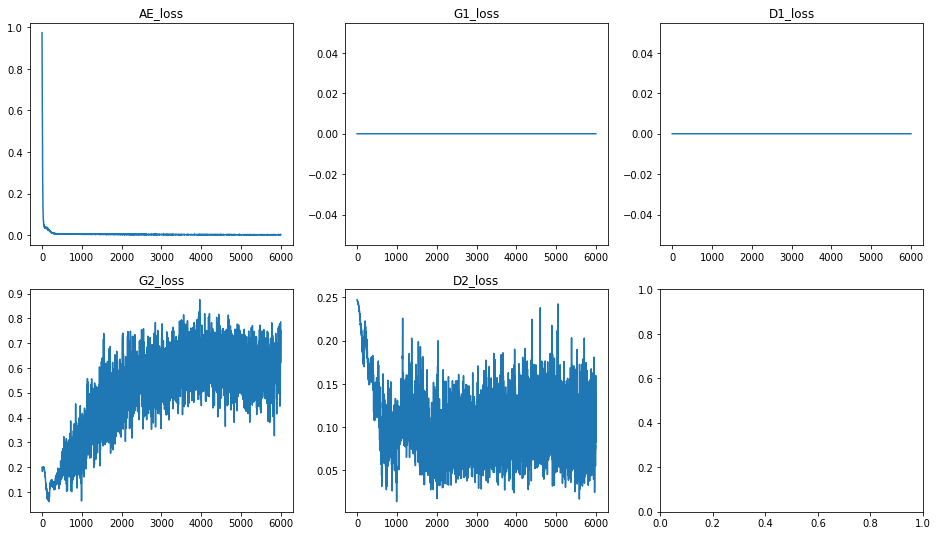

In [93]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(16,9))

ax[0, 0].plot(range(n_epochs-1), history["AE_loss"], label="AE_loss")
ax[0, 0].set_title("AE_loss")

ax[0, 1].plot(range(n_epochs-1), history["G1_loss"], label="G1_loss")
ax[0, 1].set_title("G1_loss")

ax[0, 2].plot(range(n_epochs-1), history["D1_loss"], label="D1_loss")
ax[0, 2].set_title("D1_loss")

ax[1, 0].plot(range(n_epochs-1), history["G2_loss"], label="G2_loss")
ax[1, 0].set_title("G2_loss")

ax[1, 1].plot(range(n_epochs-1), history["D2_loss"], label="D2_loss")
ax[1, 1].set_title("D2_loss")

plt.show()

In [98]:
image = train_set[-36].reshape((1,48,96,96,1))
model.autoencoder.load_weights(r'../GAN_log/autoencoder_epoch_5087.h5')
gen_image=np.squeeze(model.autoencoder.predict(image))
image = np.squeeze(image)

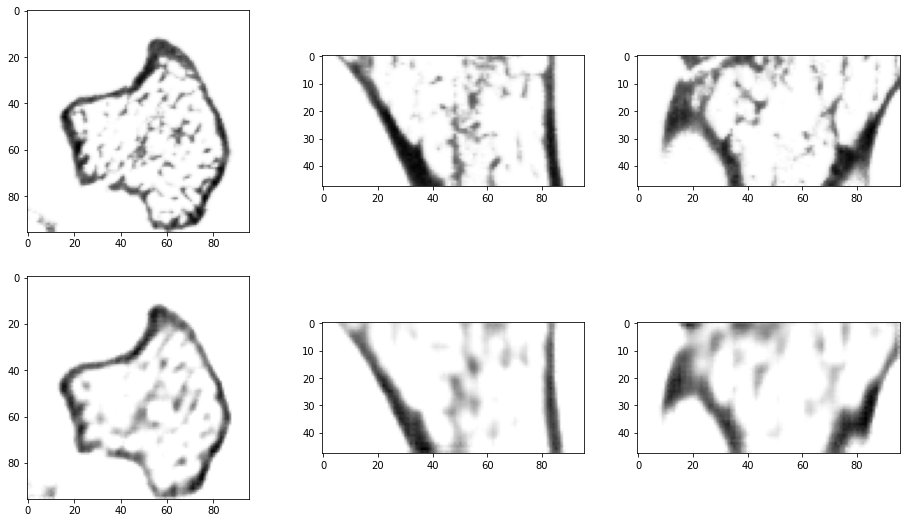

In [99]:
fig2, ax = plt.subplots(2,3, figsize=(16,9))
ax[0,0].imshow(image[35,:,:],cmap="Greys")
ax[1,0].imshow(gen_image[35,:,:],cmap="Greys")
ax[0,1].imshow(image[::-1,50,:],cmap="Greys")
ax[1,1].imshow(gen_image[::-1,50,:],cmap="Greys")
ax[0,2].imshow(image[::-1,:,60],cmap="Greys")
ax[1,2].imshow(gen_image[::-1,:,60],cmap="Greys")

In [104]:
#model = AAE(encoded_dim=256)
model.encoder.summary()

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_272 (Conv3D)          (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_273 (Conv3D)          (None, 24, 48, 48, 16)    6928      
_________________________________________________________________
batch_normalization_188 (Bat (None, 24, 48, 48, 16)    64        
_________________________________________________________________
conv3d_274 (Conv3D)          (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
batch_normalization_189 (Bat (None, 24, 48, 48, 32)    128       
_________________________________________________________________
conv3d_275 (Conv3D)          (None, 12, 24, 24, 32)    27680     
_________________________________________________________________
batch_normalization_190 (Bat (None, 12, 24, 24, 32)  

In [105]:
model.decoder.summary()

Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_transpose_184 (Conv3D (None, 6, 12, 12, 128)    3584      
_________________________________________________________________
batch_normalization_196 (Bat (None, 6, 12, 12, 128)    512       
_________________________________________________________________
conv3d_transpose_185 (Conv3D (None, 6, 12, 12, 64)     221248    
_________________________________________________________________
batch_normalization_197 (Bat (None, 6, 12, 12, 64)     256       
_________________________________________________________________
conv3d_transpose_186 (Conv3D (None, 12, 24, 24, 64)    110656    
_________________________________________________________________
batch_normalization_198 (Bat (None, 12, 24, 24, 64)    256       
_________________________________________________________________
conv3d_transpose_187 (Conv3D (None, 12, 24, 24, 32)  

In [44]:
model.discriminator2.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_103 (Conv3D)          (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_104 (Conv3D)          (None, 48, 96, 96, 16)    6928      
_________________________________________________________________
max_pooling3d_43 (MaxPooling (None, 24, 48, 48, 16)    0         
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 24, 48, 48, 32)    27680     
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 12, 24, 24, 32)    0         
_________________________________________________________________
conv3d_107 (Conv3D)          (None, 12, 24, 24, 64)  

In [52]:
for layer in model.generator.layers:
    print(layer.trainable)

True
True
True


In [57]:
model.generator2.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
sequential_50 (Sequential)   (None, 48, 96, 96, 1)     2219409   
_________________________________________________________________
sequential_52 (Sequential)   (None, 1)                 69729     
Total params: 2,219,409
Trainable params: 2,219,409
Non-trainable params: 0
_________________________________________________________________
